In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import pandas as pd
from astropy.io import ascii 
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u
import scipy
from tqdm import tqdm

### Data must be run in order start to finish

In [2]:
#list of colors to use
some_colors = ["#00c4ed","#9ac064","#cd87e8","#d85743","#5c5251"]
more_colors = ["#f78b6b","#ad91fc","#63c365","#83d2ff"]
colors2 = ["#a3e681","#2a84a2"]

#function for plot formatting
def plotting( title, x_title, y_title, show = True, myfontsize=15):
    plt.xticks(fontsize=myfontsize-4)
    plt.yticks(fontsize=myfontsize-5)
    plt.title(title, fontsize= myfontsize +2)
    plt.xlabel(x_title,fontsize=myfontsize)
    plt.ylabel(y_title,fontsize=myfontsize)
    if show:
        plt.show()

In [3]:
#getting ALMA raw data
with open('alma_all.txt') as f:
    content = f.readlines()
    alma = ascii.read(content, names = ['velocity','l:c'])
alma['velocity'].unit = u.km /u.s
alma['l:c'].unit = u.dimensionless_unscaled

In [4]:
#getting data
with open('PH3.txt') as f:
    content = f.readlines()
    columns = ['velocity', 'l:c']
    data = ascii.read(content, names = columns) 
data['velocity']
data['velocity'].unit = u.km /u.s
data['l:c'].unit = 3*10**4 * u.dimensionless_unscaled
data['verr'] = np.full(len(data), 5)
data['verr'].unit = u.km /u.s

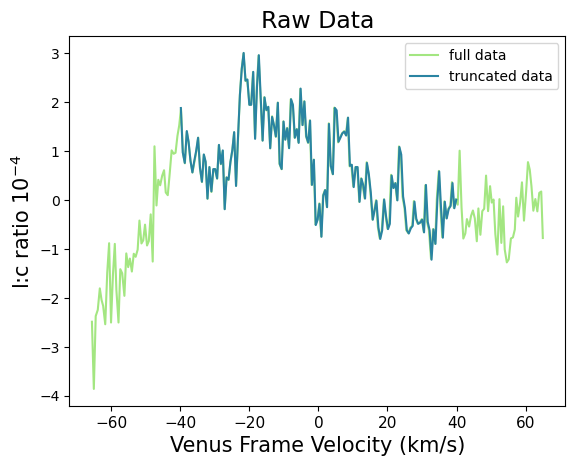

In [5]:
#plotting 2 datas on top of each other

plt.plot(alma['velocity'], alma['l:c'] * 10**4 , alpha = 1, color = colors2[0], label = "full data")
plt.plot(data['velocity'], data['l:c'], alpha = 1, color = colors2[1], label = "truncated data") #, linestyle = 'dotted')
plt.legend()
plotting("Raw Data", "Venus Frame Velocity (km/s)", r"l:c ratio $10^{-4}$")


# Working first with truncated data set

In [6]:
#masked data has all data not in dip were examining 
#dip_data is just the data of this dip
masked_table = data[abs(data['velocity']) > 5]
dip_data = data[abs(data['velocity']) <= 5]


# making matrix polynomial for plotting fit on masked data
poly_v_mask = np.ones((len(masked_table), 41))
poly_v_mask_reversed = np.ones((len(masked_table), 41))
for i in range(41):
    poly_v_mask[:,i] = masked_table['velocity'].value**i
    poly_v_mask_reversed[:,-(i+1)] = masked_table['velocity'].value**i
    

def get_fit(deg, coefficients = False):
    #this will fit degree given to the masked table 
    coeff = np.polyfit(masked_table['velocity'], masked_table['l:c'], deg)
    fit = np.matmul(poly_v_mask_reversed[:,-(1+deg):], coeff)
    if coefficients:
        return fit, coeff
    return(fit)

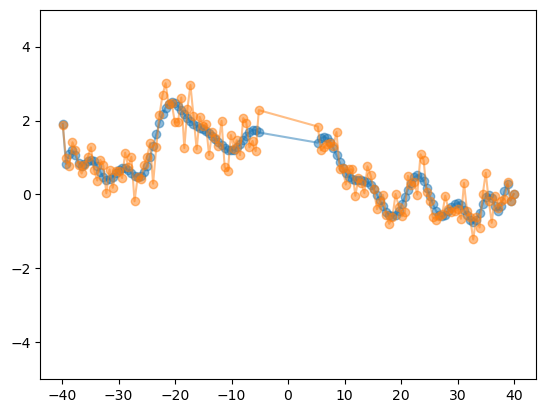

In [7]:
#plotting a fit from above
plt.plot(masked_table['velocity'], get_fit(28), marker = 'o', alpha=.5)
plt.plot(masked_table['velocity'], masked_table['l:c'], marker = 'o', alpha=.5)

plt.ylim(-5,5)
plt.show()

How the data is scored in def score_deg \
$k$ = number of parameters \
$N$ = number of points being fit
$$
    \text{BIC} = -2 \log (\mathcal{L}) + k \log N =  χ^2 + k \log N \\
    \text{AIC} = -2 \log (\mathcal{L}) + 2k =  χ^2 + 2k \\
    \text{AICc} = \text{AIC} + 2\frac{k^2 + k}{n-k-1}
$$
How depth(δ) and SNR calculated
$$
δ = \text{Average(corrected flux outside dip)} - \text{Average(corrected flux inside dip)} $$
    
$$
\text{SNR} = \frac{δ}{Δδ}\\
Δδ = σ_\text{corrected flux outside dip} \\
$$

In [8]:
# making matrix polynomial for plotting fit on dip data 
poly_v_dip_reversed = np.ones((len(dip_data), 41))
for i in range(41):
    poly_v_dip_reversed[:,-(i+1)] = dip_data['velocity'].value**i


def score_deg(deg):
    """ This funtions takes in degree
    It will fit the data to the masked data set and evaluate and return the:
    BIC, AIC, AICc on the masked data, 
    Depth and Signal to Noise Ratio of the masked transit
    """
    fit, coeff = get_fit(deg,  coefficients = True)
    chi2 = np.dot((masked_table['l:c'] - fit ) **2, 1/(masked_table['verr']**2))
    k = deg + 1
    n = len(masked_table)
    
    BIC = chi2 + k*np.log(n)
    AIC = chi2 + 2*k
    AICc = AIC + 2*(k**2 + k)/(n - k -1)
    
    dip_fit = np.matmul(poly_v_dip_reversed[:,-(1+deg):], coeff)
    depth = ( np.average(masked_table['l:c'] - fit )) - \
            (np.average( dip_data['l:c'] - dip_fit))
    
    residual = (fit - masked_table['l:c'])
    Δdepth = np.sqrt((np.std(fit - masked_table['l:c']))**2 )
    SN = depth / Δdepth
    return  BIC, AIC, AICc, depth, SN, residual


In [9]:
#looping above function to get scores using score_deg
scores = np.zeros((40, 6))
residuals_trunc = np.zeros((40, 128))
for i in range(40):
    score = score_deg(i+1)
    residuals_trunc[i, :] = score[-1]
    scores[i, :] = [int(i+1), *score[:5]]

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)


In [10]:
#creating table of these truncated data scores
scores_table_trunc = Table(scores, names = ['degree', 'BIC', 'AIC', 'AICc', 'depth', 'Signal Noise'])
scores_table_trunc

degree,BIC,AIC,AICc,depth,Signal Noise
float64,float64,float64,float64,float64,float64
1.0,12.465453160823234,6.761392632984,6.857392632984,0.03572554692769697,0.04864629686181987
2.0,16.725058055679654,8.168967263920804,8.362515651017578,0.47487293245028384,0.7296018012893725
3.0,21.210106787516,9.801985731837533,10.127188983870052,0.4747406493693698,0.8002316534162707
4.0,25.82213040049294,11.56197908089486,12.053782359583384,0.8067258453212776,1.4605732576703265
5.0,30.58306098285256,13.470879399334857,14.165094275367915,0.8066152355931897,1.5049181104863842
6.0,35.37500050770317,15.410788660265851,16.344121993599185,0.6088564082087653,1.1598955486215117
...,...,...,...,...,...
34.0,170.45316043752942,70.6321012003428,98.02340554816888,3.441986297127612,9.79604587022108
35.0,175.29717656506725,72.62408706396104,101.89881233868631,3.4285662898789986,9.820304199434108


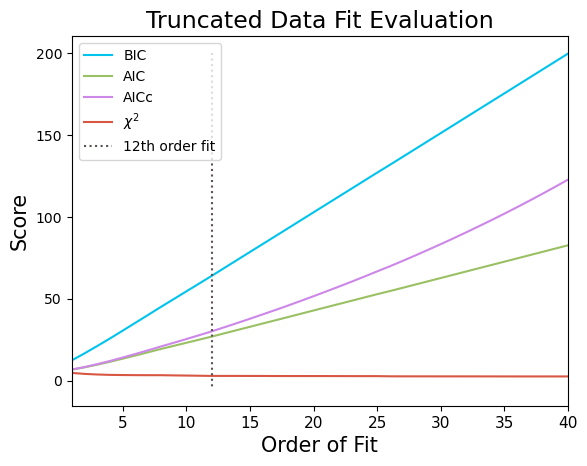

In [11]:
#plotting scores above
score_type = ['BIC', 'AIC', 'AICc']
for i in range(3):
    plt.plot(scores_table_trunc['degree'], scores_table_trunc[score_type[i]] ,
             label = score_type[i], color = some_colors[i])
plt.plot(scores_table_trunc['degree'], scores_table_trunc['AIC'] - 2* scores_table_trunc['degree'],
         label = r'$χ^2$', color = some_colors[3])

plt.vlines(12, 200, -5, color= some_colors[-1], label = '12th order fit', linestyles='dotted')
plt.xlim(1, 40)
#plt.ylim(0, 200)
plt.legend()
plotting("Truncated Data Fit Evaluation", "Order of Fit", "Score")




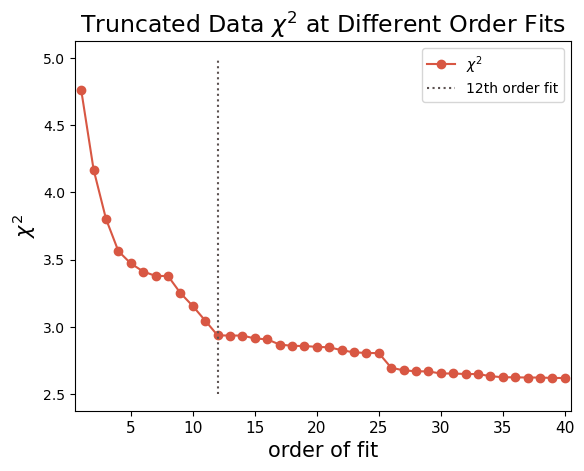

In [12]:
# plotting just the χ^2
plt.plot(scores_table_trunc['degree'], scores_table_trunc['AIC'] - 2* scores_table_trunc['degree'],
         label = r'$χ^2$', color = some_colors[3], marker = 'o')
plt.vlines(12, 2.5, 5, color= some_colors[-1], label = '12th order fit', 
           linestyles='dotted')
#plt.ylim(2.5, 4.8)
plt.xlim(.5, 40.5)
plt.legend()
plotting(r"Truncated Data $χ^2$ at Different Order Fits", "order of fit",r'$χ^2$')

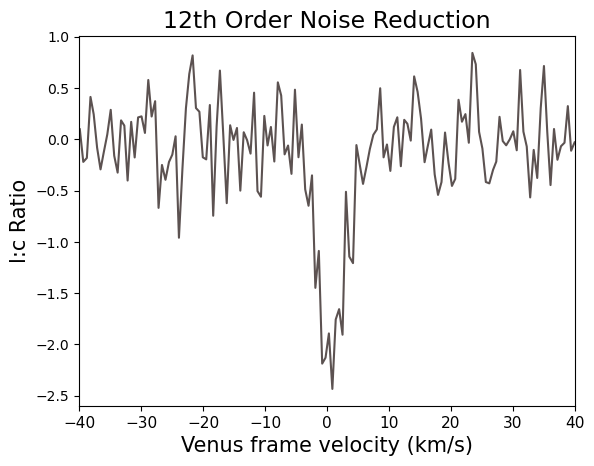

In [13]:
#plotting a fit from above
fit12, coeff12 = get_fit(12,  coefficients = True)

dip_fit12 =  np.matmul(poly_v_dip_reversed[:,-13:], coeff12)
plot12_v = [*masked_table['velocity'][:64], *dip_data['velocity'], *masked_table['velocity'][65:]]
plot12_ic = np.array([*(masked_table['l:c'][:64]- fit12[:64]), *(dip_data['l:c']- dip_fit12),
                      *(masked_table['l:c'][65:]- fit12[65:])])*12.8/16.1


plt.plot(plot12_v,(plot12_ic),  color = some_colors[-1])
plt.xlim(-40, 40)

plotting("12th Order Noise Reduction", "Venus frame velocity (km/s)","l:c Ratio")

## calculated weighted average depth
δ = depth
$$
<δ> = \frac{\sum \exp(-ΔBIC_i) δ_i}{\sum \exp(-ΔBIC_i)} \\
 = (\sum \exp(-ΔBIC_i) δ_i)/(\sum \exp(-ΔBIC_i)) \\
 =  (\exp(-ΔBIC_i) \cdot δ_i)/(\sum \exp(-ΔBIC_i))
$$
Same is done for $<\text{SNR}>$

## calculated weighted average SNR
$$
<\text{SNR}> = \frac{\sum_{i=1}^{40} \exp(-ΔBIC_i) \text{SNR}_i}{\sum_{i=1}^{40} \exp(-ΔBIC_i)} \\ \\
 = (\sum \exp(-ΔBIC_i) δ_i)/(\sum \exp(-ΔBIC_i)) \\
 =  (\exp(-ΔBIC_i) \cdot δ_i)/(\sum \exp(-ΔBIC_i))
$$

In [14]:
#calculating the weighted depth
BICs_t = scores_table_trunc['BIC'].value
depths_t = scores_table_trunc['depth'].value
ΔBICs_t = BICs_t - BICs_t[np.argmin(BICs_t)]
wa_δ_t = np.dot(np.exp(-ΔBICs_t), depths_t) / np.sum(np.exp(-ΔBICs_t))
wa_δ_t

In [16]:
#calculating the weighted SNR
BICs_t = scores_table_trunc['BIC'].value
SNR_t = scores_table_trunc['Signal Noise'].value
ΔBICs_t = BICs_t - BICs_t[np.argmin(BICs_t)]
wa_SNR_t = np.dot(np.exp(-ΔBICs_t), SNR_t) / np.sum(np.exp(-ΔBICs_t))
#signal to noise of weighted models
wa_SNR_t

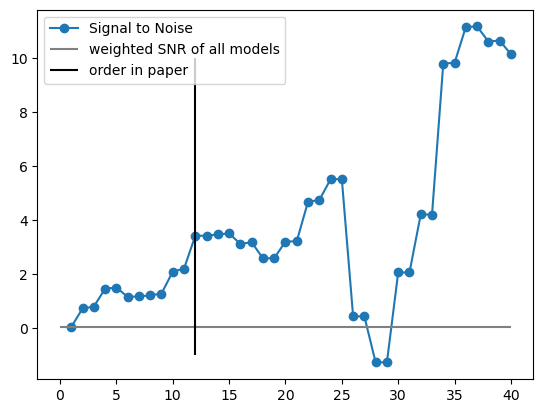

In [55]:
#plotting SNR vs Polynomial order
plt.plot(scores_table_trunc['degree'], scores_table_trunc['Signal Noise'], label = 'Signal to Noise', marker = 'o')
plt.hlines(wa_SNR_t, 0, 40, color= 'grey', label = 'weighted SNR of all models')
plt.vlines(12, 10, -1, color= 'k', label = 'order in paper')
plt.legend()

# Working now with non-truncated data set
Repeating the steps from above with different data set

In [19]:
#changing data set
alma['verr'] = np.full(len(alma), 5)
alma['verr'].unit = u.km /u.s

alma['l:c'] = alma['l:c'] * 1e4

#masked data has all data not in dip were examining 
#dip_data is just the data of this dip
masked_table = alma[abs(alma['velocity']) > 5]
dip_data = alma[abs(alma['velocity']) <= 5]


# making matrix polynomial for plotting fit on masked data
poly_v_mask = np.ones((len(masked_table), 41))
poly_v_mask_reversed = np.ones((len(masked_table), 41))
for i in range(41):
    poly_v_mask[:,i] = masked_table['velocity'].value**i
    poly_v_mask_reversed[:,-(i+1)] = masked_table['velocity'].value**i
    
# making matrix polynomial for plotting fit on dip data 
poly_v_dip_reversed = np.ones((len(dip_data), 41))
for i in range(41):
    poly_v_dip_reversed[:,-(i+1)] = dip_data['velocity'].value**i



In [21]:
#looping above function to get scores using score_deg
scores = np.zeros((40, 6))
residuals_full = np.zeros((40, 221))
for i in range(40):
    score = score_deg(i+1)
    residuals_full[i, :] = score[-1]
    scores[i, :] = [int(i+1), *score[:5]]


/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)


In [22]:
#creating table of these truncated data scores
scores_table_full = Table(scores, names = ['degree', 'BIC', 'AIC', 'AICc', 'depth', 'Signal Noise'])
scores_table_full[11]

degree,BIC,AIC,AICc,depth,Signal Noise
float64,float64,float64,float64,float64,float64
12.0,72.50601592486356,28.32990080513278,30.088354911412974,0.6464192264116542,1.259133219308883


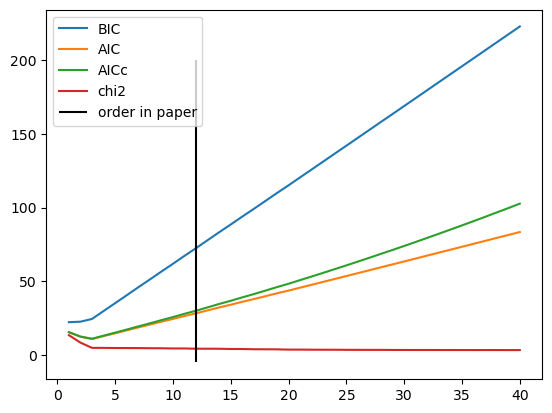

In [23]:
#plotting scores above
score_type = ['BIC', 'AIC', 'AICc']
for i in range(3):
    plt.plot(scores_table_full['degree'], scores_table_full[score_type[i]] , label = score_type[i])
plt.plot(scores_table_full['degree'], scores_table_full['AIC'] - 2* scores_table_full['degree'], label = 'chi2')
plt.vlines(12, 200, -5, color= 'k', label = 'order in paper')
plt.legend()
plt.show()

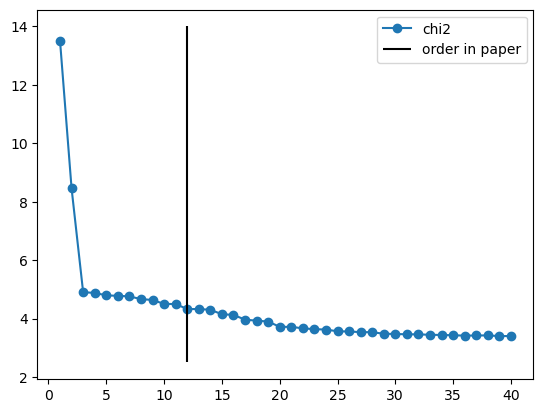

In [24]:
# plotting just the χ^2
plt.plot(scores_table_full['degree'], scores_table_full['AIC'] - 2* scores_table_full['degree'], label = 'chi2', marker = 'o')
plt.vlines(12,2.5, 14, color= 'k', label = 'order in paper')
plt.legend()

## calculated weight average depth of full data

In [25]:
BICs_f = scores_table_full['BIC'].value
depths_f = scores_table_full['depth'].value
ΔBICs_f = BICs_f - BICs_f[np.argmin(BICs_f)]
wa_δ_f = np.dot(np.exp(-ΔBICs_f), depths_f) / np.sum(np.exp(-ΔBICs_f))
wa_δ_f

-0.0845508819045553

In [26]:
BICs_f = scores_table_full['BIC'].value
SNR_f = scores_table_full['Signal Noise'].value
ΔBICs_f = BICs_f - BICs_f[np.argmin(BICs_f)]
wa_SNR_f = np.dot(np.exp(-ΔBICs_f), SNR_f) / np.sum(np.exp(-ΔBICs_f))
wa_SNR_f

-0.0038191861135426866

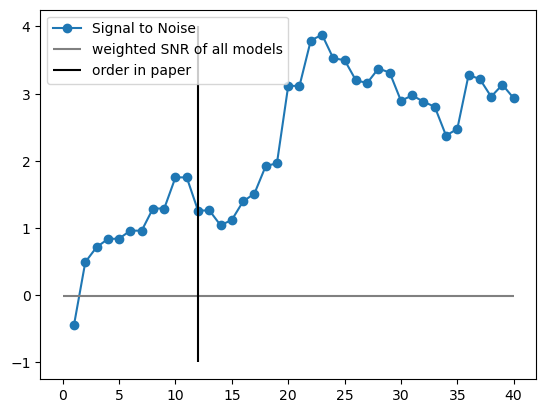

In [54]:
#plotting SNR vs Polynomial order
plt.plot(scores_table_full['degree'], scores_table_full['Signal Noise'], label = 'Signal to Noise', marker = 'o')
plt.hlines(wa_SNR_f, 0, 40, color= 'grey', label = 'weighted SNR of all models')
plt.vlines(12, 4, -1, color= 'k', label = 'order in paper')
plt.legend()


# getting false positive data

In [29]:
#creating new data set
no_5v = alma[abs(alma['velocity']) > 5].copy()

#empty tables for values
false_positive_SNR = np.full((40, 147), np.nan)
false_positive_SNR[:,0] = range(1,41)

sucessful_iteration = 0 #number of iterations where SNR is calculated
for index in tqdm(range(len(no_5v) - 18)):
    #choosen dip area to evaluate start and finish velocity 
    v_i = no_5v['velocity'][index]
    v_f = no_5v['velocity'][index + 18]
    
    if v_i > -55:
        if v_f < -5:
            #get desired data location
            sucessful_iteration += 1
            
            #ititalize data to use
            masked_index = np.setdiff1d(range(len(no_5v)), range(index, index + 18))
            masked_table = no_5v[masked_index]
            dip_data = no_5v[index:index + 18]
            
            
            # making matrix polynomial for plotting fit on masked data
            poly_v_mask = np.ones((len(masked_table), 41))
            poly_v_mask_reversed = np.ones((len(masked_table), 41))
            for i in range(41):
                poly_v_mask[:,i] = masked_table['velocity'].value**i
                poly_v_mask_reversed[:,-(i+1)] = masked_table['velocity'].value**i

            # making matrix polynomial for plotting fit on dip data 
            poly_v_dip_reversed = np.ones((len(dip_data), 41))
            for i in range(41):
                poly_v_dip_reversed[:,-(i+1)] = dip_data['velocity'].value**i
            
            #inputting data
            for i in range(40):
                false_positive_SNR[i, sucessful_iteration] = score_deg(i+1)[-2]

        elif 5 < v_i:
            if v_f < 55:
                #get desired data location
                sucessful_iteration += 1
                
                #ititalize data to use
                masked_index = np.setdiff1d(range(len(no_5v)), range(index, index + 18))
                masked_table = no_5v[masked_index]
                dip_data = no_5v[index:index + 18]
                
                # making matrix polynomial for plotting fit on masked data
                poly_v_mask = np.ones((len(masked_table), 41))
                poly_v_mask_reversed = np.ones((len(masked_table), 41))
                for i in range(41):
                    poly_v_mask[:,i] = masked_table['velocity'].value**i
                    poly_v_mask_reversed[:,-(i+1)] = masked_table['velocity'].value**i

                # making matrix polynomial for plotting fit on dip data 
                poly_v_dip_reversed = np.ones((len(dip_data), 41))
                for i in range(41):
                    poly_v_dip_reversed[:,-(i+1)] = dip_data['velocity'].value**i
                
                #inputting data
                for i in range(40):
                    false_positive_SNR[i, sucessful_iteration] = score_deg(i+1)[-2]


  0%|                                                   | 0/203 [00:00<?, ?it/s]/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpd

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Poly

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Poly

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Poly

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Poly

 39%|████████████████▌                         | 80/203 [00:02<00:03, 31.92it/s]/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpd

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
 45%|███████████████████                       | 92/203 [00:02<00:03, 32.85it/s]/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpd

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Poly

/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Poly

 71%|█████████████████████████████▎           | 145/203 [00:03<00:01, 35.43it/s]/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpd

 78%|███████████████████████████████▉         | 158/203 [00:03<00:01, 36.80it/s]/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpd

 84%|██████████████████████████████████▎      | 170/203 [00:04<00:00, 35.55it/s]/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpd

 90%|████████████████████████████████████▊    | 182/203 [00:04<00:00, 34.90it/s]/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpdtnhn1zsf6j1vr_121z5w0000gn/T/ipykernel_50852/3152744812.py:13: RankWarning: Polyfit may be poorly conditioned
  fit, coeff = get_fit(deg,  coefficients = True)
/var/folders/3n/2mpd

In [30]:
false_positive_SNR[0, 1:]

array([ 0.75466239,  0.63959363,  0.53616655,  0.46080192,  0.35588135,
        0.23454541,  0.15400713,  0.04469447, -0.0800682 , -0.19831586,
       -0.36211368, -0.46688893, -0.52689567, -0.68067964, -0.6831775 ,
       -0.73502942, -0.7419038 , -0.76814597, -0.79521518, -0.83287895,
       -0.85983903, -0.87368732, -0.89359604, -0.87658545, -0.82097498,
       -0.80158531, -0.73277305, -0.67768746, -0.60281079, -0.57120099,
       -0.59067729, -0.55060109, -0.53856273, -0.48334089, -0.47689935,
       -0.4553538 , -0.44204362, -0.42617354, -0.46559497, -0.46065664,
       -0.47834229, -0.55422398, -0.70513928, -0.84304254, -0.97761071,
       -1.090479  , -1.17059104, -1.26363662, -1.36184096, -1.39372911,
       -1.48051865, -1.69347187, -1.80720388, -1.85905941, -1.95380177,
       -2.01141303, -2.04849096, -2.09835939, -2.12949647, -2.078086  ,
       -1.96476534, -1.87968543, -1.75637778, -1.6270772 , -1.60182901,
       -1.55183888, -1.47087065, -1.45676454, -1.43769163, -1.36

In [31]:
#putting into astrpy table
false_positive_table = Table(false_positive_SNR, names = ['degree', *range(1, 147)])


In [32]:
false_positive_table

degree,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0,0.7546623919705123,0.6395936293045441,0.536166545011235,0.46080192126323566,0.3558813457664162,0.23454540978045113,0.15400713432796023,0.044694474119174876,-0.08006820233733103,-0.1983158646679013,-0.36211367759865776,-0.46688892883747596,-0.5268956723821526,-0.68067963927742,-0.683177502300162,-0.7350294184889367,-0.7419037956693396,-0.7681459746795616,-0.7952151830228663,-0.8328789456598574,-0.8598390336141697,-0.8736873171952201,-0.8935960447049228,-0.8765854544679493,-0.8209749806924284,-0.8015853066537634,-0.7327730483339695,-0.6776874579287445,-0.6028107900949777,-0.5712009927303491,-0.5906772863642855,-0.550601094201305,-0.538562734040199,-0.4833408895336154,-0.4768993528316864,-0.4553537993012844,-0.44204362074016385,-0.42617353937247043,-0.46559496665949335,-0.46065663911067306,-0.47834229168923065,-0.5542239848229995,-0.7051392796740543,-0.8430425431889687,-0.9776107134838998,-1.0904789999431912,-1.1705910409209508,-1.2636366244604205,-1.3618409602578176,-1.3937291140475483,-1.4805186487171267,-1.6934718660964734,-1.8072038848654584,-1.8590594097305473,-1.9538017691832505,-2.0114130258857905,-2.048490957690266,-2.098359393676224,-2.129496467843227,-2.078085999719897,-1.9647653434677355,-1.879685427999007,-1.7563777803115646,-1.6270772039546724,-1.6018290095980379,-1.5518388835947374,-1.4708706516758552,-1.456764540698029,-1.4376916332658045,-1.365019933462949,-1.3090484486809681,-1.3226709122138012,-1.2628999555208262,-0.6366655366061104,-0.5460060910056451,-0.46292403852251107,-0.3849161354968489,-0.31324359160332244,-0.21112047532647987,-0.10137812383217719,0.01796881965628716,0.05317502103640505,0.10805913003820707,0.1535443453054172,0.21423355074349326,0.222630611271247,0.2079716337097506,0.21321595197889684,0.22993071781714775,0.1746827591434465,0.16655118886793208,0.19125780551060517,0.20854353101740788,0.22071404542312562,0.2467002314920012,0.2775079663768768,0.2771742621356381,0.2370522504471622,0.22469236953662583,0.25186317342364967,0.2593899615049281,0.24967604320179992,0.26007984102475135,0.27187358067097744,0.3098460270783456,0.3628581773249515,0.4304006822038174,0.522680419162394,0.6236746478225295,0.6277034952297585,0.5871732731767302,0.5634014201420476,0.5697713305734986,0.5408665189093688,0.5335840640821972,0.5436378802704672,0.529961647523076,0.4837334857785345,0.46844

# Combination Graphs

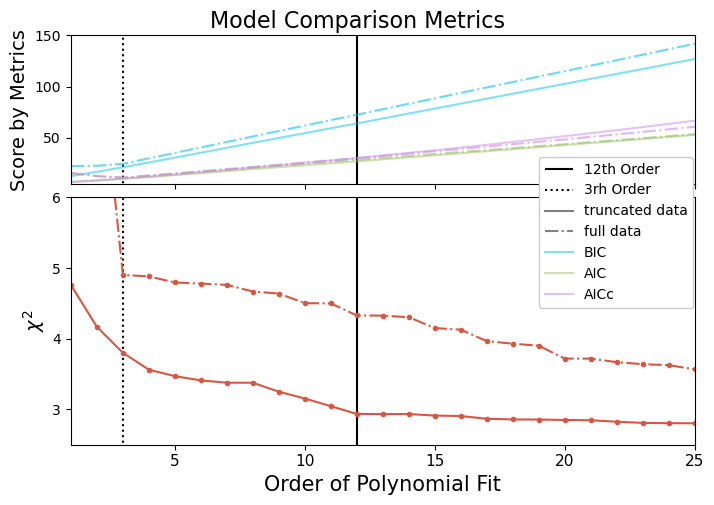

In [47]:
#plotting scores (short version)
score_type = ['BIC', 'AIC', 'AICc']

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 5]}, sharex=True)


#gs(height_ratios  = (1,4))
#line for 12th order
axs[0].vlines(12, 250, -5, color= 'k', alpha = 1,
           label = '12th Order') 
axs[1].vlines(12, 250, -5, color= 'k', alpha = 1) 

axs[0].vlines(3, 250, -5, color= 'k', alpha = 1, linestyle= 'dotted',
           label = '3rh Order') 
axs[1].vlines(3, 250, -5, color= 'k', alpha = 1, linestyle= 'dotted',) 

#plots just for label sake
axs[0].plot([None], [None], color = 'grey', label = 'truncated data')
axs[0].plot([None], [None], color = 'grey', label = 'full data', linestyle = 'dashdot')

#first truncated data
for i in range(3):
    axs[0].plot(scores_table_trunc['degree'], scores_table_trunc[score_type[i]],
             color = some_colors[i], alpha = 0.5)
    axs[0].plot([None], [None], color = some_colors[i], label = score_type[i], alpha = 0.5)

## plotting chi^2
axs[1].plot(scores_table_trunc['degree'], scores_table_trunc['AIC'] - 2* scores_table_trunc['degree'],
         color = some_colors[3],  marker = '.')


#full data
for i in range(3):
    axs[0].plot(scores_table_full['degree'], scores_table_full[score_type[i]] , 
              color = some_colors[i],  linestyle = 'dashdot', alpha = 0.6)
## plotting chi^2
axs[1].plot(scores_table_full['degree'], scores_table_full['AIC'] - 2* scores_table_full['degree'],
        color = some_colors[3], linestyle = 'dashdot',  marker = '.')


axs[0].set_ylim(5, 150)
axs[1].set_ylim(2.5, 6)
axs[1].set_xlim(1, 25)
axs[0].set_xlim(1, 25)

myfontsize = 15 

plt.xticks(fontsize=myfontsize-4)
plt.yticks(fontsize=myfontsize-5)
fig.suptitle("Model Comparison Metrics", fontsize= myfontsize +1)
axs[1].set_xlabel('Order of Polynomial Fit',fontsize=myfontsize )
axs[1].set_ylabel(r'$χ^2$',fontsize=myfontsize-1)
axs[1].set_yticks(ticks = [3, 4, 5, 6])
axs[0].set_ylabel('Score by Metrics',fontsize=myfontsize -1)

#fig.legend(bbox_to_anchor=(1.22, .95))
fig.legend(framealpha=1, bbox_to_anchor=(.99, .7))
axs[0].label_outer()
fig.set_figwidth(7)
fig.tight_layout(pad=.2)
fig.set_figheight(5)
#plotting("Model Comparison Metrics", "Order of Polynomial Fit", "Score by Metric")



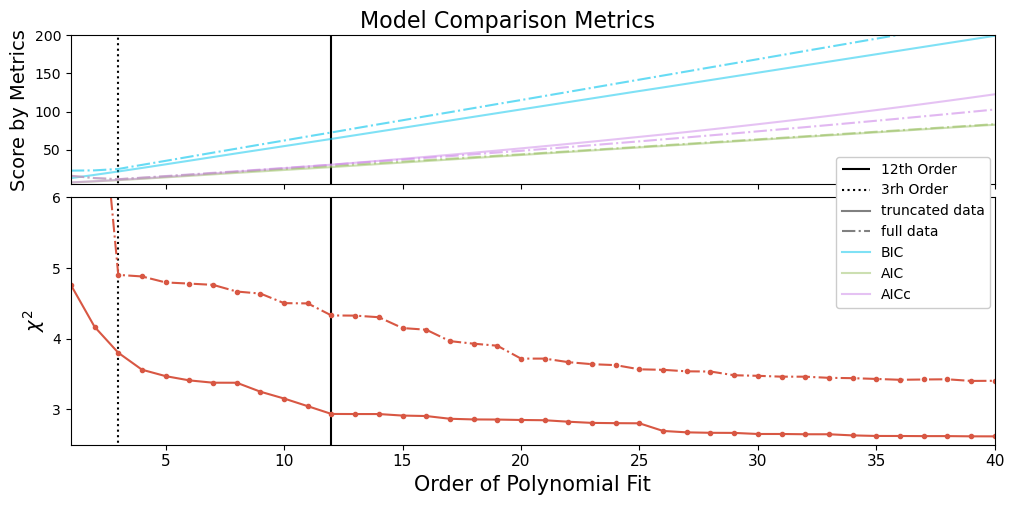

In [48]:
#plotting scores (long version)
score_type = ['BIC', 'AIC', 'AICc']

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 5]}, sharex=True)


#gs(height_ratios  = (1,4))
#line for 12th order
axs[0].vlines(12, 250, -5, color= 'k', alpha = 1,
           label = '12th Order') 
axs[1].vlines(12, 250, -5, color= 'k', alpha = 1) 

axs[0].vlines(3, 250, -5, color= 'k', alpha = 1, linestyle= 'dotted',
           label = '3rh Order') 
axs[1].vlines(3, 250, -5, color= 'k', alpha = 1, linestyle= 'dotted',) 

#plots just for label sake
axs[0].plot([None], [None], color = 'grey', label = 'truncated data')
axs[0].plot([None], [None], color = 'grey', label = 'full data', linestyle = 'dashdot')

#first truncated data
for i in range(3):
    axs[0].plot(scores_table_trunc['degree'], scores_table_trunc[score_type[i]],
             color = some_colors[i], alpha = 0.5)
    axs[0].plot([None], [None], color = some_colors[i], label = score_type[i], alpha = 0.5)

## plotting chi^2
axs[1].plot(scores_table_trunc['degree'], scores_table_trunc['AIC'] - 2* scores_table_trunc['degree'],
         color = some_colors[3],  marker = '.')


#full data
for i in range(3):
    axs[0].plot(scores_table_full['degree'], scores_table_full[score_type[i]] , 
              color = some_colors[i],  linestyle = 'dashdot', alpha = 0.6)
## plotting chi^2
axs[1].plot(scores_table_full['degree'], scores_table_full['AIC'] - 2* scores_table_full['degree'],
        color = some_colors[3], linestyle = 'dashdot',  marker = '.')


axs[0].set_ylim(5, 200)
axs[1].set_ylim(2.5, 6)
axs[1].set_xlim(1, 40)
axs[0].set_xlim(1, 40)

myfontsize = 15 

plt.xticks(fontsize=myfontsize-4)
plt.yticks(fontsize=myfontsize-5)
fig.suptitle("Model Comparison Metrics", fontsize= myfontsize +1)
axs[1].set_xlabel('Order of Polynomial Fit',fontsize=myfontsize )
axs[1].set_ylabel(r'$χ^2$',fontsize=myfontsize-1)
axs[1].set_yticks(ticks = [3, 4, 5, 6])
axs[0].set_ylabel('Score by Metrics',fontsize=myfontsize -1)

#fig.legend(bbox_to_anchor=(1.22, .95))
fig.legend(framealpha=1, bbox_to_anchor=(.99, .7))
axs[0].label_outer()
fig.set_figwidth(10)
fig.tight_layout(pad=.2)
fig.set_figheight(5)

#plotting("Model Comparison Metrics", "Order of Polynomial Fit", "Score by Metric")
plt.savefig('MCM.pdf')


In [38]:
print(wa_SNR_t, wa_SNR_f)

0.05825149952971407 -0.0038191861135426866


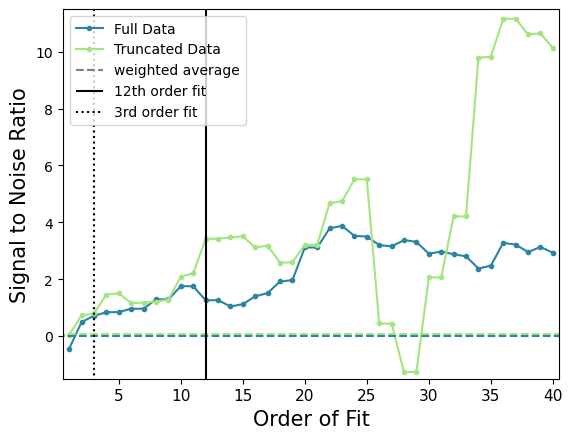

In [50]:
#Plotting SNR

plt.plot(scores_table_full['degree'], scores_table_full['Signal Noise'], 
         label = 'Full Data', marker = '.',
         color = colors2[1])
plt.plot(scores_table_trunc['degree'], scores_table_trunc['Signal Noise'], 
         label = 'Truncated Data', marker = '.',
        color = colors2[0])
#plotting weighted averages
plt.hlines(wa_SNR_t, 0, 40.5, color= colors2[0], linestyles='dashed')
plt.hlines(wa_SNR_f, 0, 40.5, color= colors2[1], linestyles='dashed')
plt.hlines(0, 0, 0, color= 'grey', linestyles='dashed',
           label = 'weighted average')
plt.vlines(12, 11.5,-1.5, label = '12th order fit', color = 'k')
plt.vlines(3, 11.5,-1.5, label = '3rd order fit', color = 'k', linestyle = 'dotted')
plt.xlim(.5,40.5)
plt.ylim(-1.5, 11.5)
plt.legend()
plotting('', 'Order of Fit', 'Signal to Noise Ratio', show = False)
plt.savefig('SNR.pdf')

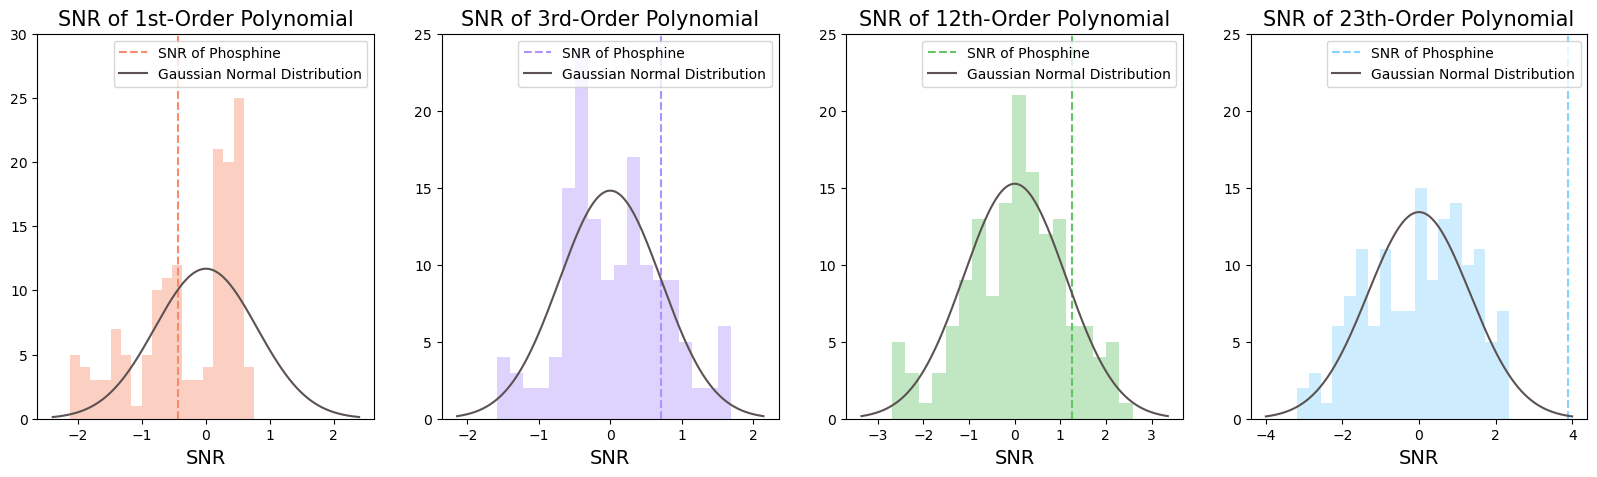

In [51]:
from scipy import stats
num_bins = 18

myfontsize=15
degrees = [1,3,12, 23]

degreeth = ['1st', '3rd', '12th', '23th']
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1,1,1,1]})

#plotting normal fits over FPD
for i in range(4):
    
    degree = degrees[i]
    SNR = false_positive_SNR[degree -1, 1:]
    SNR_phos = scores_table_full['Signal Noise'][degree-1]
    
    #plotting false positive histogram
    axs[i].hist(SNR, bins = num_bins, facecolor= more_colors[i] , alpha=0.4)
    
    #plotting SNR of that fit
    axs[i].vlines(SNR_phos, 0, 40, 
               label = 'SNR of Phosphine', color = more_colors[i], linestyle = 'dashed')

    #plotting appropreate noramal distribution
    N = len(SNR)
    std = np.std(false_positive_SNR[degree -1, 1:], ddof =1)
    y = np.linspace(-3, 3, 1000)
    bin_width = (max(SNR) - min(SNR)) / num_bins
    
    axs[i].plot(y * std, stats.norm.pdf(y) * N * bin_width / std, 
             label = 'Gaussian Normal Distribution', color = some_colors[-1])
    axs[i].legend()
    axs[i].set_ylim(0,25)
    axs[i].set_xlabel(r'SNR',fontsize=myfontsize-1)
    axs[i].set_title(f'SNR of {degreeth[i]}-Order Polynomial',fontsize=myfontsize)


axs[0].set_ylim(0,30)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.savefig('FPP.pdf')